In [73]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from omegaconf import OmegaConf
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import instantiate
from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_lines import IAMLines
from text_recognizer.network.transformer.embeddings.sincos import sincos_2d

In [74]:
t = sincos_2d(20, 18, 128, 1e1)

In [75]:
t.shape

torch.Size([360, 128])

In [76]:
t

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.8007,  0.7591,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9093,  0.9594,  0.9883,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [ 0.6503,  0.9778,  0.3550,  ..., -0.5920, -0.4580, -0.3233],
        [-0.2879,  0.7535,  0.9408,  ..., -0.5920, -0.4580, -0.3233],
        [-0.9614, -0.0750,  0.8698,  ..., -0.5920, -0.4580, -0.3233]])

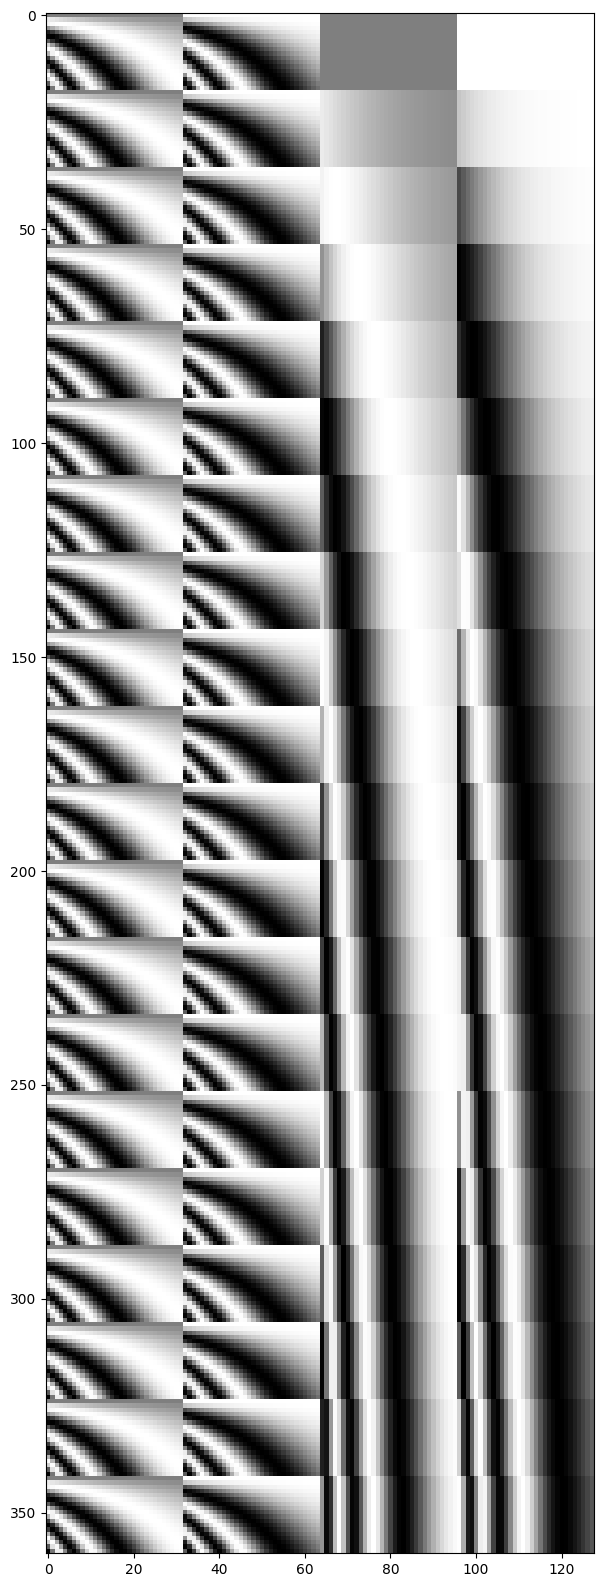

In [77]:
plt.figure(figsize=(40, 20))
plt.imshow(t, cmap='gray')

In [43]:
tt = torch.randn(20 * 18, 128)

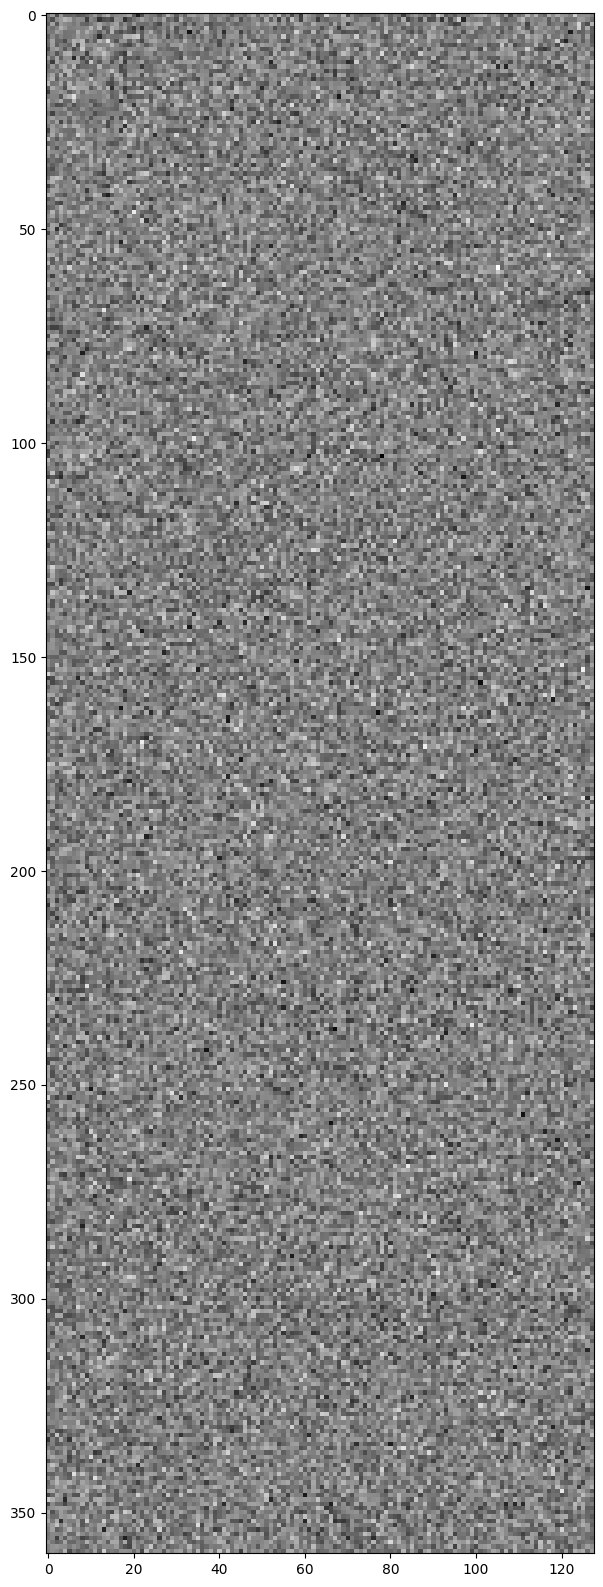

In [44]:
plt.figure(figsize=(40, 20))
plt.imshow(tt, cmap='gray')

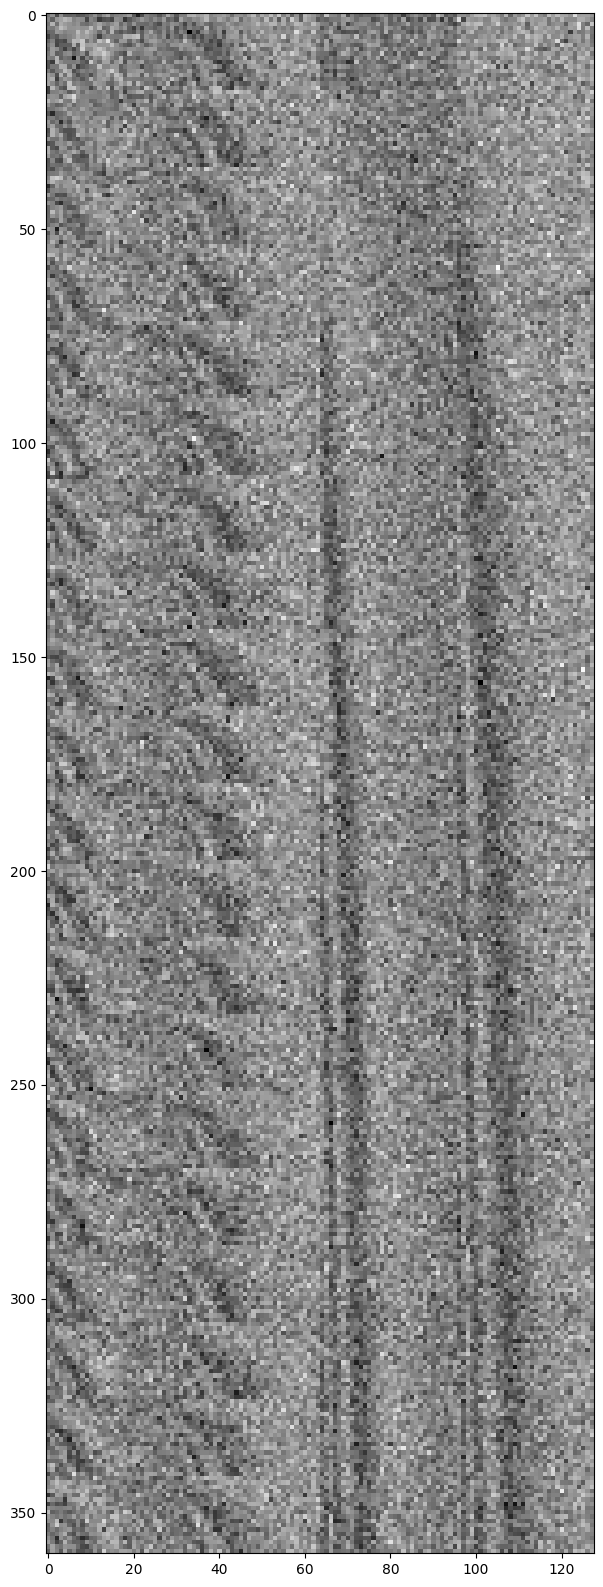

In [45]:
plt.figure(figsize=(40, 20))
plt.imshow(tt + t, cmap='gray')

In [46]:
import math

import torch
from torch import Tensor
import torch.nn as nn


class PositionalEncodingImage(nn.Module):
    """
    Module used to add 2-D positional encodings to the feature-map produced by the encoder.

    Following https://arxiv.org/abs/2103.06450 by Sumeet Singh.
    """

    def __init__(self, d_model: int, max_h: int = 2000, max_w: int = 2000, persistent: bool = False) -> None:
        super().__init__()
        self.d_model = d_model
        assert d_model % 2 == 0, f"Embedding depth {d_model} is not even"
        pe = self.make_pe(d_model=d_model, max_h=max_h, max_w=max_w)  # (d_model, max_h, max_w)
        self.register_buffer(
            "pe", pe, persistent=persistent
        )  # not necessary to persist in state_dict, since it can be remade

    @staticmethod
    def make_pe(d_model: int, max_h: int, max_w: int) -> torch.Tensor:
        pe_h = PositionalEncoding.make_pe(d_model=d_model // 2, max_len=max_h)  # (max_h, 1 d_model // 2)
        pe_h = pe_h.permute(2, 0, 1).expand(-1, -1, max_w)  # (d_model // 2, max_h, max_w)

        pe_w = PositionalEncoding.make_pe(d_model=d_model // 2, max_len=max_w)  # (max_w, 1, d_model // 2)
        pe_w = pe_w.permute(2, 1, 0).expand(-1, max_h, -1)  # (d_model // 2, max_h, max_w)

        pe = torch.cat([pe_h, pe_w], dim=0)  # (d_model, max_h, max_w)
        return pe

    def forward(self, x: Tensor) -> Tensor:
        """pytorch.nn.module.forward"""
        # x.shape = (B, d_model, H, W)
        assert x.shape[1] == self.pe.shape[0]  # type: ignore
        x = x + self.pe[:, : x.size(2), : x.size(3)]  # type: ignore
        return x


class PositionalEncoding(torch.nn.Module):
    """Classic Attention-is-all-you-need positional encoding."""

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000, persistent: bool = False) -> None:
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        pe = self.make_pe(d_model=d_model, max_len=max_len)  # (max_len, 1, d_model)
        self.register_buffer(
            "pe", pe, persistent=persistent
        )  # not necessary to persist in state_dict, since it can be remade

    @staticmethod
    def make_pe(d_model: int, max_len: int) -> torch.Tensor:
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x.shape = (S, B, d_model)
        assert x.shape[2] == self.pe.shape[2]  # type: ignore
        x = x + self.pe[: x.size(0)]  # type: ignore
        return self.dropout(x)

In [50]:
pe = PositionalEncodingImage(4, 20, 18)

In [51]:
x = torch.randn(1, 4, 20, 18)

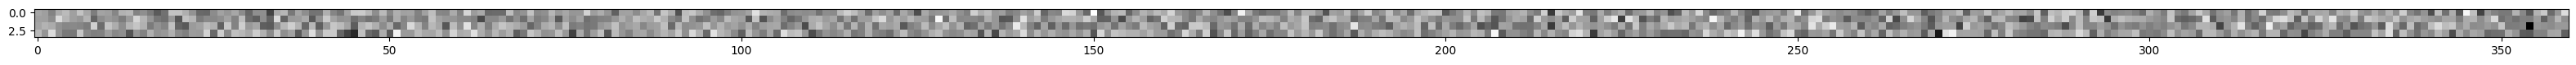

In [56]:
plt.figure(figsize=(40, 20))
plt.imshow(x.squeeze().flatten(1,2), cmap='gray')

In [57]:
xx = pe(x)

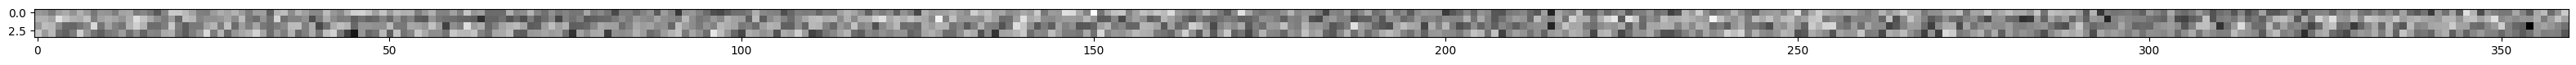

In [58]:
plt.figure(figsize=(40, 20))
plt.imshow(xx.squeeze().flatten(1,2), cmap='gray')

In [63]:
xxx = pe.make_pe(128, 20, 18).flatten(1,2)

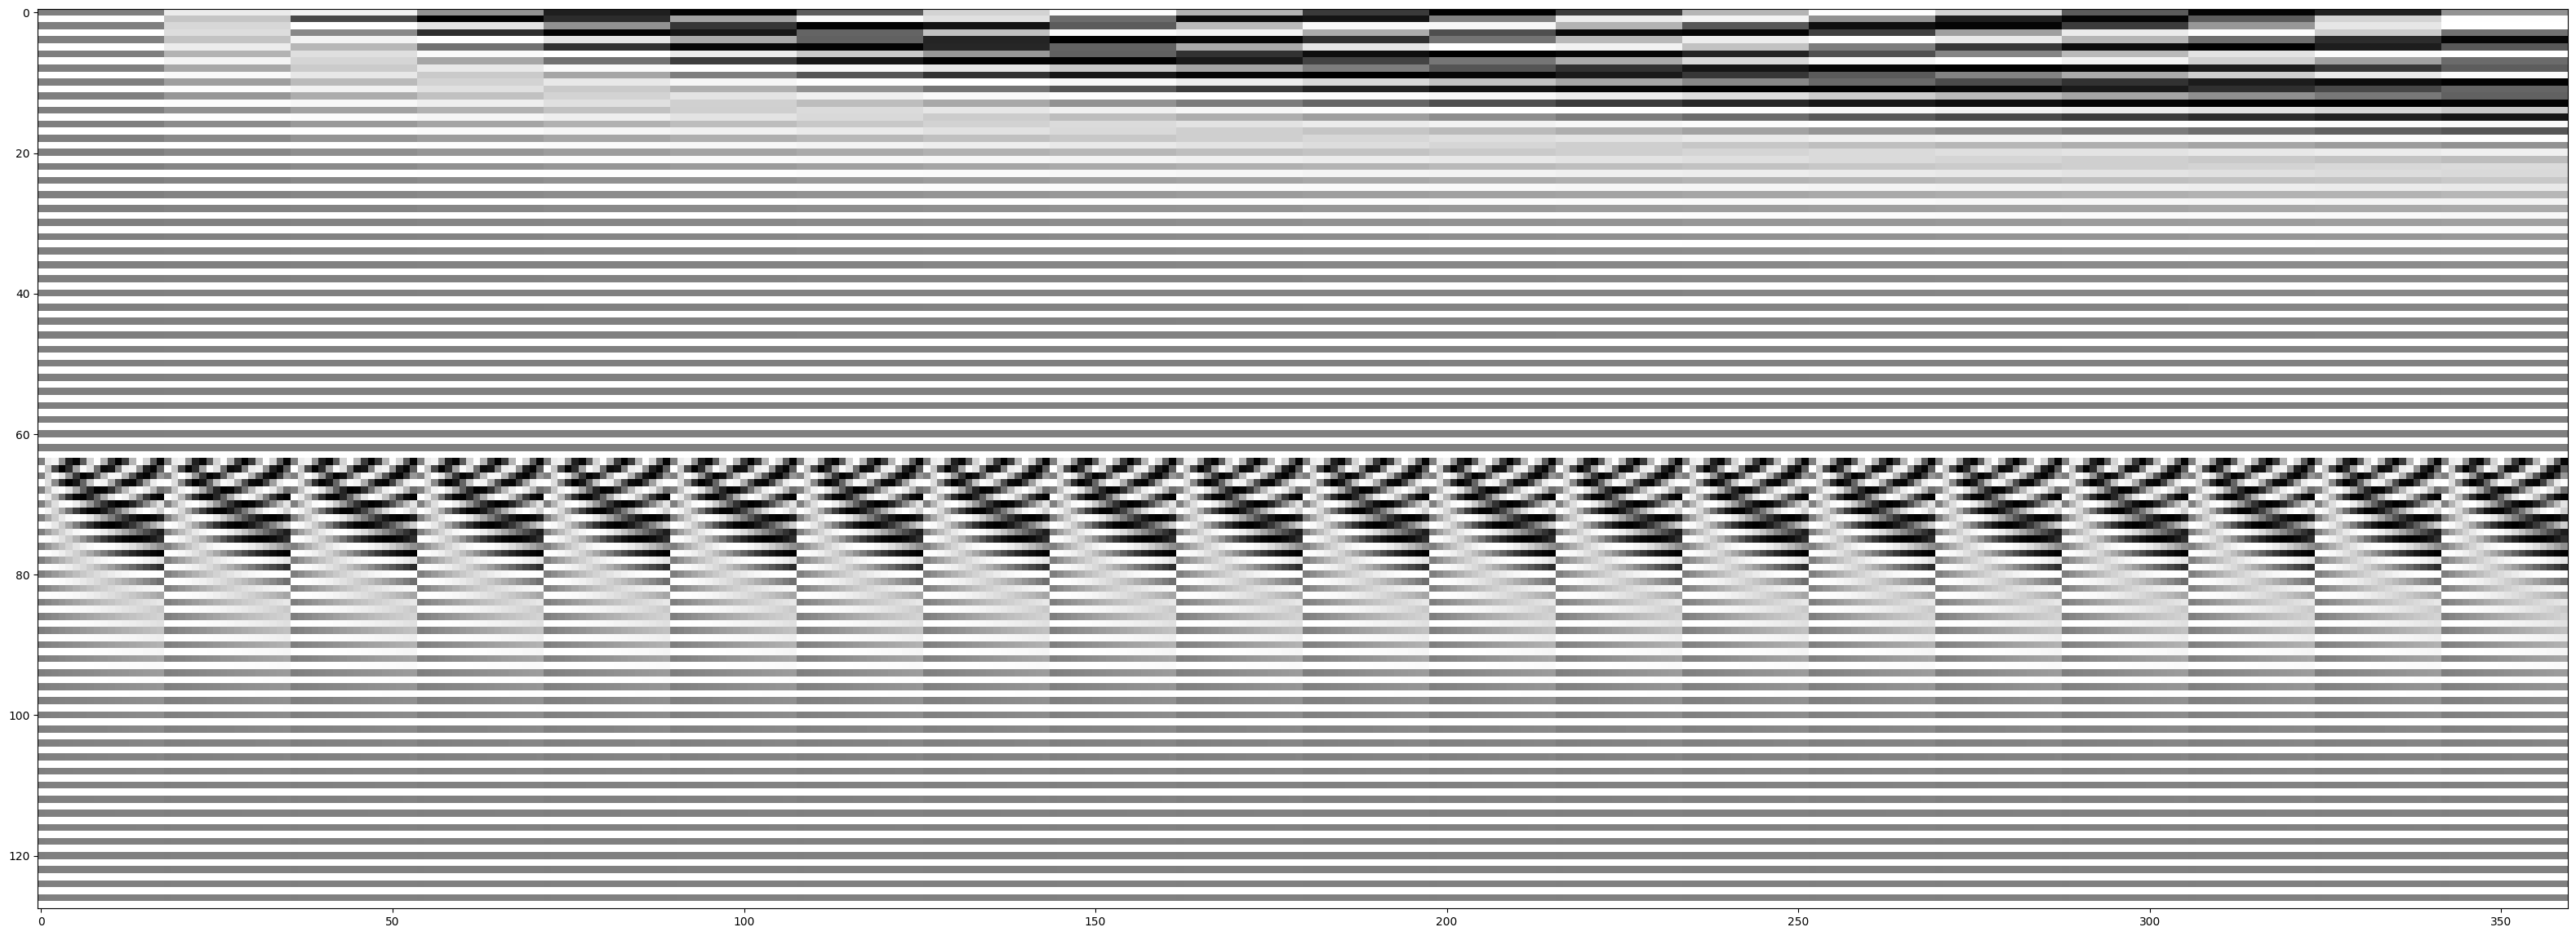

In [64]:
plt.figure(figsize=(40, 20))
plt.imshow(xxx, cmap='gray')